### INF 385 : Lecture 8

The below PCA example is derived from Sebastian Raschka: http://sebastianraschka.com/Articles/2014_pca_step_by_step.html#what-is-a-good-subspace

In [1]:
# hide warnings to keep things tidy.
import warnings
warnings.filterwarnings('ignore')

import numpy as np
np.random.seed(1) 

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch
%pylab inline

import sklearn # for later

Populating the interactive namespace from numpy and matplotlib


In [2]:
# set means and variances for two hypothetical classes
mu_vec1 = np.array([0,0,0])
cov_mat1 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat1, 20).T

mu_vec2 = np.array([1,1,1])
cov_mat2 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat2, 20).T

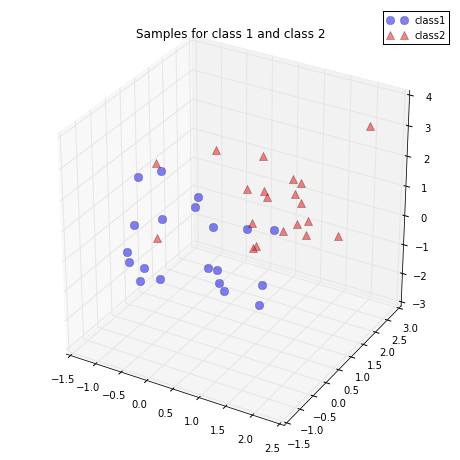

In [3]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(class1_sample[0,:], class1_sample[1,:], class1_sample[2,:], 'o', markersize=8, color='blue', alpha=0.5, label='class1')
ax.plot(class2_sample[0,:], class2_sample[1,:], class2_sample[2,:], '^', markersize=8, alpha=0.5, color='red', label='class2')

plt.title('Samples for class 1 and class 2')
ax.legend(loc='upper right');

In [4]:
# merge the classes; we don't care about them here
all_samples = np.concatenate((class1_sample, class2_sample), axis=1)

In [5]:
# calculate the means for each attribute (column) across examples
mean_x = np.mean(all_samples[0,:])
mean_y = np.mean(all_samples[1,:])
mean_z = np.mean(all_samples[2,:])

mean_vector = np.array([[mean_x],[mean_y],[mean_z]])

print('Mean Vector:\n', mean_vector)

Mean Vector:
 [[ 0.41667492]
 [ 0.69848315]
 [ 0.49242335]]


In [6]:
# now we want to calculate the covariances between variables
cov_mat = np.cov([all_samples[0,:],all_samples[1,:],all_samples[2,:]])
print('Covariance Matrix:\n', cov_mat)

Covariance Matrix:
 [[ 0.9868668   0.26943262  0.2855759 ]
 [ 0.26943262  0.92914135  0.30682016]
 [ 0.2855759   0.30682016  1.27528118]]


In [7]:
# eigenvectors and eigenvalues for the from the covariance matrix
eig_val_cov, eig_vec_cov = np.linalg.eig(cov_mat)

In [8]:
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:,i].reshape(1,3).T
    print('Eigenvector {}: \n{}'.format(i+1, eigvec_cov))
    print('Eigenvalue {} from covariance matrix: {}'.format(i+1, eig_val_cov[i]))
    print(40 * '-')

Eigenvector 1: 
[[-0.49210223]
 [-0.47927902]
 [-0.72672348]]
Eigenvalue 1 from covariance matrix: 1.671009430532869
----------------------------------------
Eigenvector 2: 
[[-0.64670286]
 [-0.35756937]
 [ 0.67373552]]
Eigenvalue 2 from covariance matrix: 0.838325973415845
----------------------------------------
Eigenvector 3: 
[[ 0.58276136]
 [-0.8015209 ]
 [ 0.13399043]]
Eigenvalue 3 from covariance matrix: 0.6819539303101814
----------------------------------------


### Now we'll visualize the eigen-vectors

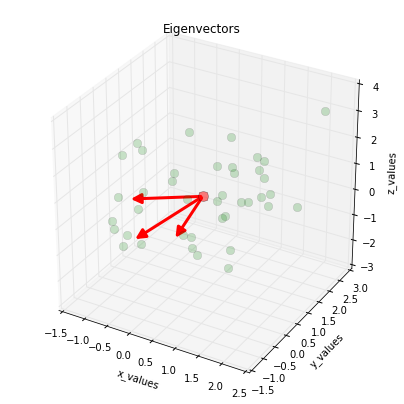

In [9]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(all_samples[0,:], all_samples[1,:], all_samples[2,:], 'o', markersize=8, color='green', alpha=0.2)
ax.plot([mean_x], [mean_y], [mean_z], 'o', markersize=10, color='red', alpha=0.5)
for v in eig_vec_cov.T:
    a = Arrow3D([mean_x, v[0]], [mean_y, v[1]], [mean_z, v[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)
ax.set_xlabel('x_values')
ax.set_ylabel('y_values')
ax.set_zlabel('z_values')

plt.title('Eigenvectors');

OK, so those are the three axes; but now we want to sort as a function of the amount of variance they capture (across points). It turns out this is exactly the same as sorting with respect to the *eigenvalues* corresponding to each *eigenvector*. 

In [10]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:,i]) for i in range(len(eig_val_cov))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
for i in eig_pairs:
    print(i[0])

1.67100943053
0.838325973416
0.68195393031


The last bit is to now *project* our three-dimensional points down into two dimensions. All we need to do is multiply our data points by the first two eigen vectors (since we set *k*=2 here). This projects the data into the new axes, which were selected to maximize the amount of variance they capture.

In [11]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(3,1), eig_pairs[1][1].reshape(3,1)))
print('Matrix W:\n', matrix_w)

Matrix W:
 [[-0.49210223 -0.64670286]
 [-0.47927902 -0.35756937]
 [-0.72672348  0.67373552]]


In [12]:
transformed = matrix_w.T.dot(all_samples)
transformed.shape

(2, 40)

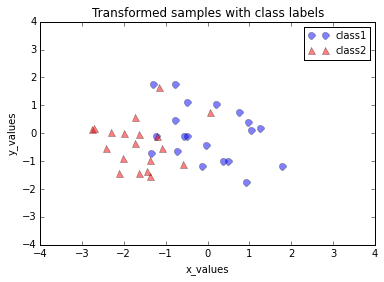

In [13]:
plt.plot(transformed[0,0:20], transformed[1,0:20], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(transformed[0,20:40], transformed[1,20:40], '^', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples with class labels')

plt.show();

### In class exercise, part 
#### 1. First transform boston housing via PCA & plot

In [14]:
from sklearn.datasets import load_boston
boston = load_boston()
print(boston.data.shape)

(506, 13)


So we have 506 examples and 13 points.

In [15]:
# PCA reduce via sklearn
## as usual, sklearn makes our lives easy!
X = boston.data
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
X_reduced = pca.transform(X)
print("Reduced dataset shape:", X_reduced.shape)

Reduced dataset shape: (506, 2)


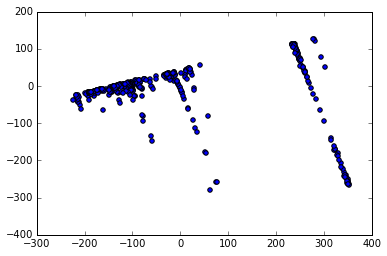

In [16]:
import pylab as pl
pl.scatter(X_reduced[:, 0], X_reduced[:, 1])

Now let's run our regression, both *in the reduced space* and in the original

In [17]:
from sklearn import linear_model
y = boston.target

# split into train/test for both reduced and regular space
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, y, random_state=0)
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = sklearn.cross_validation.train_test_split(X_reduced, y, random_state=0)
# sanity check -- the labels should be the same!!
np.testing.assert_array_equal(y_train_reduced, y_train)

In [18]:
clf_basic = linear_model.LinearRegression()
clf_reduced = linear_model.LinearRegression()
print ("fitting basic model (in the usual space)")
clf_basic.fit(X_train, y_train)
print ("fitting model to reduced data")
clf_reduced.fit(X_train_reduced, y_train_reduced)
print ("ok!")

fitting basic model (in the usual space)
fitting model to reduced data
ok!


In [19]:
basic_preds    = clf_basic.predict(X_test)
basic_errors   = sklearn.metrics.mean_squared_error(y_test, basic_preds)

reduced_preds  = clf_reduced.predict(X_test_reduced)
reduced_errors = sklearn.metrics.mean_squared_error(y_test, reduced_preds)

print ("mean squared error in original space: %s; MSE in reduced space: %s" % (basic_errors, reduced_errors))

mean squared error in original space: 29.7905591642; MSE in reduced space: 72.7594846275


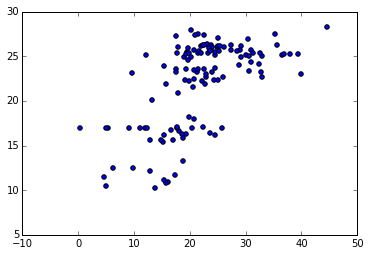

In [20]:
plt.scatter(basic_preds, reduced_preds);

In [21]:
reduced_preds[:5]

array([ 22.37619299,  16.44592448,  26.1262505 ,  16.95168486,  23.2222644 ])

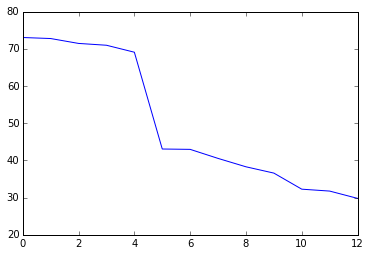

In [22]:
MSEs = []
for ndim in range(1,14):
    pca = PCA(n_components=ndim)
    pca.fit(X)
    X_reduced = pca.transform(X)

    # split into train/test in reduced space
    X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = sklearn.cross_validation.train_test_split(X_reduced, y, random_state=0)
    np.testing.assert_array_equal(y_train_reduced, y_train)

    clf_reduced = linear_model.LinearRegression()
    clf_reduced.fit(X_train_reduced, y_train_reduced)

    reduced_preds  = clf_reduced.predict(X_test_reduced)
    reduced_errors = sklearn.metrics.mean_squared_error(y_test, reduced_preds)
    MSEs.append(reduced_errors)

plt.plot(MSEs)